In [13]:
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit as cf

Below is the query for Messier 67 (a.k.a. the King Cobra Cluster!)  
As discussed, we don't need a proper motion error cut right now, just parallax error cut will suffice.  
The parameter parallax_over_error is equal to the parallax/error in parallax, so parallax_over_error > 5 means less than 20% error

In [4]:
query = '''select top 10000 source_id, ra, dec, parallax, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, pm, pmra, pmdec
from gaiadr3.gaia_source
where
ra between 132.3 and 133.3 and
dec between 11.3 and 12.3
and parallax_over_error > 5 
order by parallax desc'''

job = Gaia.launch_job_async(query)
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


We sorted by distance, so we'll have more nearby stars - so it's a good idea to use a log scale for distance. Let's make a scatter plot of apparent magnitude vs distance

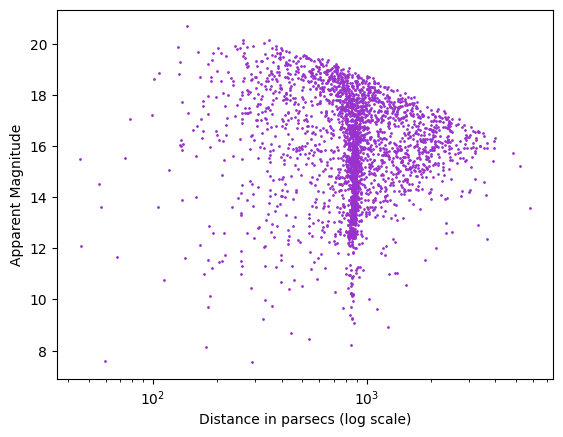

In [8]:
dist = 1000/r['parallax']
appmags = r['phot_g_mean_mag']

plt.scatter(dist, appmags, s=1, color = 'darkorchid')
plt.xscale('log')
plt.xlabel('Distance in parsecs (log scale)')
plt.ylabel('Apparent Magnitude')
plt.show()

There's a clearly visible overdensity at 800-900 pc. Let's retain only those stars from, say 500 to 1250 pc, and make a histogram

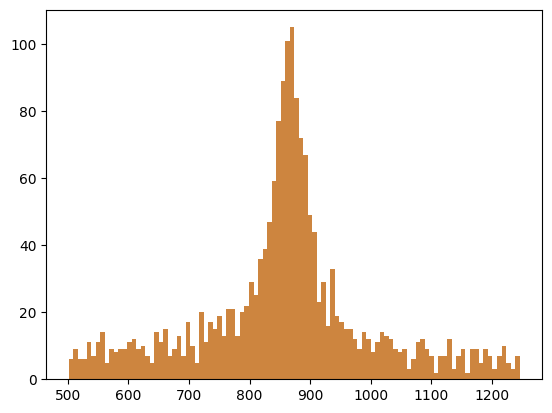

In [10]:
mask = r['parallax'] < 2
r = r[mask]
mask = r['parallax'] > 0.8
r = r[mask]

plt.hist(1000/r['parallax'], bins = 100, color = 'peru')
plt.show()

The above histogram has two components - non cluster stars that can be modelled as a uniform distribution, and the cluster stars that can be modelled as a Gaussian. Let's do curve-fitting for that.

In [21]:
def f(x, A, m, s, c):
    return A*np.exp(-(x-m)**2/(2*s**2)) + c

y, x = np.histogram(1000/r['parallax'], bins = 100)

p, c = cf(f, [(x[i] + x[i+1])/2 for i in range(100)], y, p0 = [np.max(y), x[np.argmax(y)], np.std(y), 5])

I won't be explaining the above code cell right away. You're familiar with curve fit from the selection assignment. If any of the lines do not make sense, you are encouraged to look up the syntax. If doubts still persist, message me on Slack!

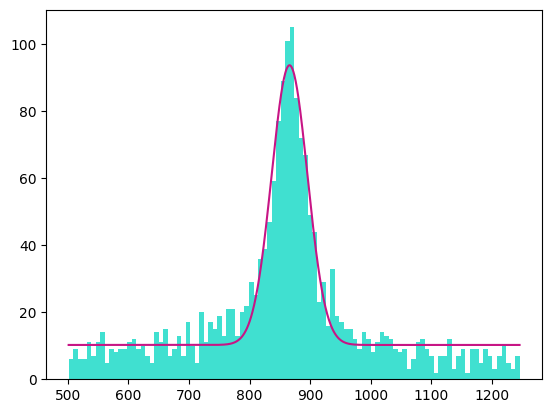

In [22]:
plt.hist(1000/r['parallax'], bins = 100, color = 'turquoise')
newx = np.linspace(x[0], x[-1], 1000)
plt.plot(newx, f(newx, p[0], p[1], p[2], p[3]), color = 'mediumvioletred')
plt.show()

The fit seems good! We can get the distance to the cluster (the mean m of curve fit) and the standard deviation (s of curve fit) and apply cuts saying stars within 3*std_dev of the mean are all cluster stars.  

That again involves using masks, I'll leave that to you. Let's just take a look at the proper motion distribution too. Recall we didn't put any error bounds on proper motion, so it might be noisy!

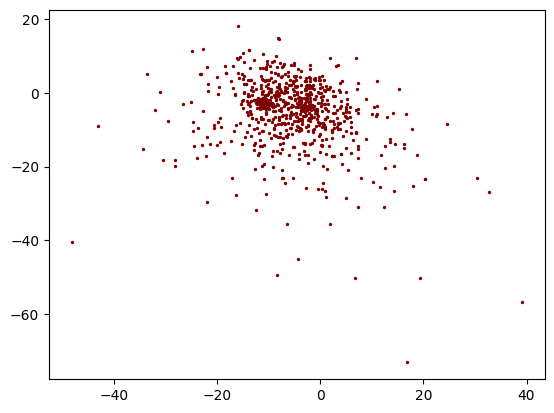

In [24]:
plt.scatter(r['pmra'], r['pmdec'], s = 2, color = 'maroon')
plt.show()

There's the usual clustering around zero, which doesn't really tell anything :)

## Tasks for next two weeks:

#### Maintain a Google doc of your work from now on. Detail on every approach you took, any peculiarities that made you change your approach, representative plots, lists and so on. We'll combine stuff into a LaTeX report later on.

### Python Tasks - 
1. Find at least 5 open clusters within say 2000 pc of Earth, that have such clear Gaussian feature above the background count. Send your list on Slack once done so that others don't spend time doing it for the same clusters as you!
2. I did not apply a proper motion error cut in my query - try applying one (again check if the datamodel already has parameters like pmra_over_error and so on), and start with > 5 for those.
3. Check if there is any clustering in proper motion space for the open clusters you choose, after applying the error cuts on those.
4. (Optional) Try constructing the HR diagrams for Messier 67, and for a few other open clusters that you find. Note particular differences that you find in the case of both.


### Reading Tasks -
Read up on the following topics, you don't need to go into too much detail. Plenty of online resources; I'll not suggest any particular one:
1. Stellar evolution and life cycle
2. Spectral classification
3. Main sequence, red giants and white dwarfs
4. HR diagrams
5. Metallicity of a star
5. Qualitative relation of age and metallicity and HR diagrams
6. Location of spectral classes in HR diagrams
6. Turnoff point


### Bonus -
The distance based method we used above to define the 'edges' of the cluster at 3*sigma is a very crude approximation. There are more refined ways based on astrometry (position and motion) alone that assign membership probability of a star belonging to a cluster or not, which are used in actual research applications with Gaia. Try reading section 2 (the classical approach) from this paper: https://academic.oup.com/mnras/article/511/4/4702/6534275?login=true  

If you don't want to, that's completely fine! If you want to and don't understand parts of it, ask. We won't be using this approach for our work, but if you are enthusiastic, you can try to code for it yourself, and try out to see how well it works on a few of the star clusters you find above!

An intermediate approach, more accurate than our current one but easier than the paper:
1. Make histogram in distance, do Gaussian fitting and 3 sigma cut on stars as we did above
2. Make histogram in RA*cos(dec) - remember spherical geometry! - and do Gaussian fitting and 3 sigma cut on it
3. Do the same for declination

If you want to be still more accurate, repeat it for pmra and pmdec.